In [1]:
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from roboflow import Roboflow
import ast
import boto3
import botocore
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import pathlib
import random
import shutil
import time
import torch
from torchvision.transforms import v2 as transforms
import torch
from torchvision.transforms import v2 as transforms
from torchvision import tv_tensors
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import yaml
import yaml

# Load environment variables from .env file
load_dotenv()

True

In [2]:
base_path = os.environ["DATASET_BASE_PATH_EXPLORE"]
try:
    shutil.rmtree(base_path)
except:
    pass
os.mkdir(base_path)

In [3]:
s3 = boto3.resource('s3')
BUCKET = "sjsu-fall24-data298-team6-bucket"
KEY = 'dataset/yolo.zip' # download whichever dataset format you need
try:
    s3.Bucket(BUCKET).download_file(KEY, f'{base_path}/data.zip')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise


In [4]:
!unzip -q $DATASET_BASE_PATH_EXPLORE/data.zip -d $DATASET_BASE_PATH_EXPLORE/data

# VisDrone Dataset

In [5]:
base_path = Path(base_path) / "data"
with open(base_path / "data.yaml", "r") as f:
    yaml_file = yaml.safe_load(f)

In [6]:
print(yaml_file)

{'names': ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor'], 'nc': 10, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}


In [7]:
classes = yaml_file["names"]
print("Classes in dataset:", classes)
print("Number of classes in dataset: ", len(classes))
print("Number of training images: ", len(os.listdir(base_path / "train/images")))
print("Number of testing images: ", len(os.listdir(base_path / "test/images")))
print("Number of validation images: ", len(os.listdir(base_path / "valid/images")))

Classes in dataset: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']
Number of classes in dataset:  10
Number of training images:  5176
Number of testing images:  648
Number of validation images:  647


In [8]:
def class_counts_per_split(split):
    split_path = base_path / split / "labels"
    class_counts = {}
    for label in os.listdir(split_path):
        with open(split_path / label, "r") as f:
            lines = f.read().splitlines()
        for line in lines:
            class_id = line.split()[0]
            class_id = int(class_id)
            try:
                class_counts[class_id] += 1
            except:
                class_counts[class_id] = 1

    class_count_with_name = {}
    print(f"{split} split")
    print("Class name           | count")
    print("----------------------------")
    for i, c in enumerate(classes):
        try:
            count = class_counts[i]
        except:
            count = 0
        print(f"{c:<20} | {count}")
        class_count_with_name[c] = count
    return class_count_with_name

In [9]:
train_count = class_counts_per_split("train")

train split
Class name           | count
----------------------------
pedestrian           | 62714
people               | 21928
bicycle              | 8474
car                  | 115371
van                  | 19988
truck                | 10474
tricycle             | 3862
awning-tricycle      | 2637
bus                  | 4915
motor                | 24107


In [10]:
test_count = class_counts_per_split("test")

test split
Class name           | count
----------------------------
pedestrian           | 7777
people               | 2449
bicycle              | 923
car                  | 15090
van                  | 2590
truck                | 1255
tricycle             | 494
awning-tricycle      | 295
bus                  | 564
motor                | 2847


In [11]:
valid_count = class_counts_per_split("valid")

valid split
Class name           | count
----------------------------
pedestrian           | 8846
people               | 2682
bicycle              | 1083
car                  | 14406
van                  | 2378
truck                | 1146
tricycle             | 456
awning-tricycle      | 314
bus                  | 447
motor                | 2693


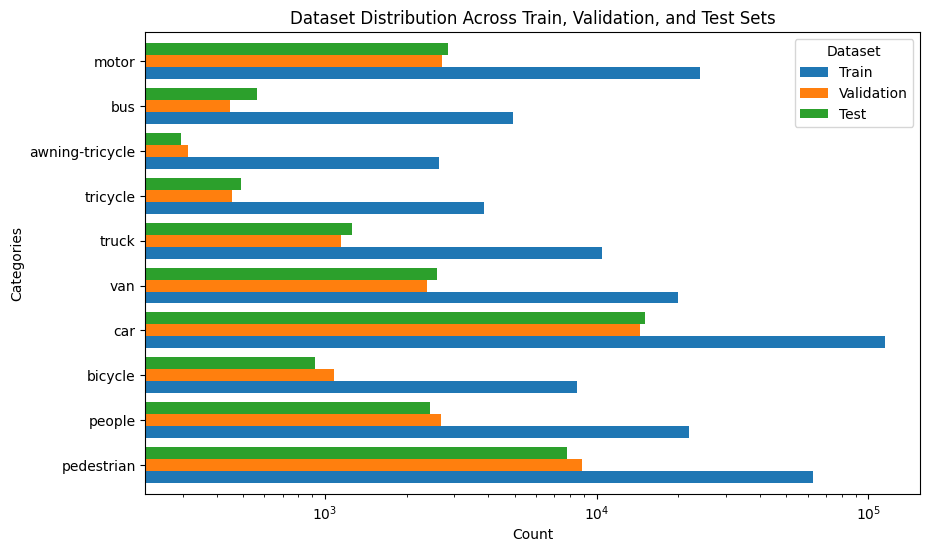

In [12]:
# Create a DataFrame
data = {"Train": train_count, "Validation": valid_count, "Test": test_count}
df = pd.DataFrame(data)

# Plotting
df.plot(kind="barh", figsize=(10, 6), width=0.8)

# Labels and title
plt.xlabel("Count")
plt.ylabel("Categories")
plt.title("Dataset Distribution Across Train, Validation, and Test Sets")
plt.xscale("log")
plt.legend(title="Dataset")

plt.show()

In [13]:
img_sizes = []
bbx_sizes = []
num_label = []
img_sizes_xy = []
bbx_sizes_xy = []
for split in ["train", "valid", "test"]:
    split_path = base_path / split / "labels"
    for label in os.listdir(split_path):
        label_file = split_path / label
        image_file = Path(label_file.parent.parent / "images" / label_file.parts[-1]).with_suffix(".jpg")
        img = Image.open(image_file)
        imgw, imgh = img.size
        with open(label_file, "r") as f:
            lines = f.read().splitlines()
        x = 0
        for line in lines:
            _,_,w,h = line.split()[1:]
            w = int(float(w) * imgw) + 1
            h = int(float(h) * imgh) + 1
            bbx_sizes.append(w * h)
            bbx_sizes_xy.append([w,h])
            x += 1
        num_label.append(x)
        img_sizes.append(imgw * imgh)
        img_sizes_xy.append([imgw, imgh])

In [14]:
pd.Series(img_sizes_xy).value_counts()

[1400, 1050]    2498
[1400, 788]     1299
[2000, 1500]     772
[1360, 765]      743
[1916, 1078]     537
[1920, 1080]     339
[960, 540]       250
[1398, 1048]      30
[1389, 1042]       1
[480, 360]         1
[1344, 756]        1
Name: count, dtype: int64

In [15]:
pd.Series(bbx_sizes_xy).value_counts()

[11, 11]      1367
[8, 16]       1359
[8, 11]       1224
[8, 8]        1176
[7, 11]       1130
              ... 
[161, 168]       1
[200, 244]       1
[283, 187]       1
[134, 106]       1
[278, 160]       1
Name: count, Length: 22236, dtype: int64

In [16]:
avg_img = sum(img_sizes) / len(img_sizes)
avg_bbx = sum(bbx_sizes) / len(bbx_sizes)
avg_num = sum(num_label) / len(num_label)

max_img_size = max(img_sizes)
min_img_size = min(img_sizes)
max_bbx_size = max(bbx_sizes)
min_bbx_size = min(bbx_sizes)

print(f"{'Average Image Area:':<45}{avg_img:.6f} px^2")
print(f"{'Average Bounding Box Area:':<45}{avg_bbx:.6f} px^2")
print(f"{'Ratio of Bounding Box Area to Image Area:':<45}{avg_bbx / avg_img * 100:.6f}%")
print(f"{'Average Number of Classifications per Image:':<45}{int(avg_num)}")
print("\nImage Sizes:")
print(f" - Max: {max_img_size}")
print(f" - Min: {min_img_size}")
print("\nBounding Box Sizes:")
print(f" - Max: {max_bbx_size}")
print(f" - Min: {min_bbx_size}")

Average Image Area:                          1573546.484006 px^2
Average Bounding Box Area:                   2493.606550 px^2
Ratio of Bounding Box Area to Image Area:    0.158470%
Average Number of Classifications per Image: 53

Image Sizes:
 - Max: 3000000
 - Min: 172800

Bounding Box Sizes:
 - Max: 329847
 - Min: 4


In [17]:
visual_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(),
    ]
)

In [18]:
font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')

def xywh2xyxy(x,y,w,h):
    xl = x - w/2
    xr = x + w/2
    yt = y - h/2
    yb = y + h/2
    return xl, yt, xr, yb

def display_image_with_bbox(img_path, label_path, title=None, transform=None):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img)
    imgw, imgh = img.size
    
    with open(label_path, "r") as f:
        labels = f.read().splitlines()
    
    boxes = []
    classes = []
    for label in labels:
        c, x, y, w, h = label.split()
        c = int(c)
        classes.append(yaml_file["names"][c])
        
        x = float(x) * imgw
        y = float(y) * imgh
        w = float(w) * imgw
        h = float(h) * imgh
        bbox = xywh2xyxy(x,y,w,h)
        boxes.append(bbox)

    boxes = tv_tensors.BoundingBoxes(
        boxes,
        format="XYXY",
        canvas_size=(imgh, imgw)
    )
    
    if transform is not None:
        img_tensor, boxes = transform(img_tensor, boxes)
        img = transforms.ToPILImage()(img_tensor)
        fz = 10
        lw = 1
    else:
        fz = 36
        lw = 5

    font = ImageFont.truetype(font_path, size=fz)
    bbox_draw = ImageDraw.Draw(img)
    for box, class_name in zip(boxes.tolist(), classes):
        bbox_draw.rectangle(box, outline="green", width=lw)
        bbox_draw.text((box[0] - fz, box[1] - fz), class_name, font=font)

    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()

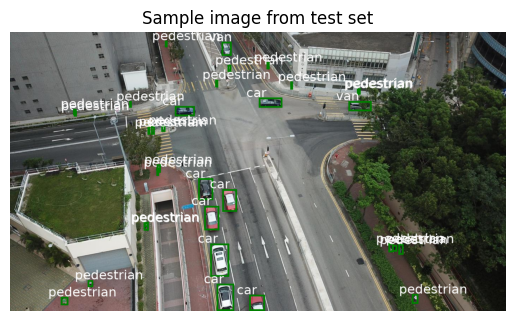

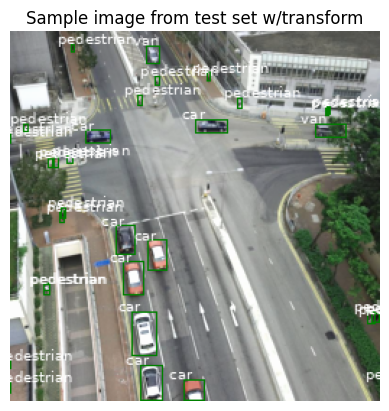

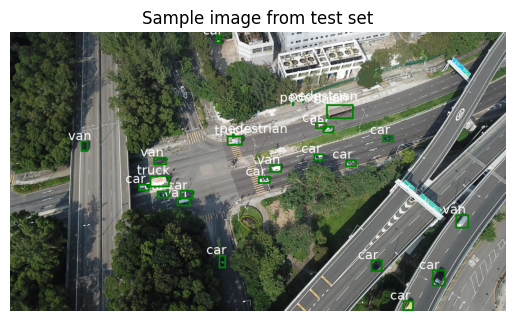

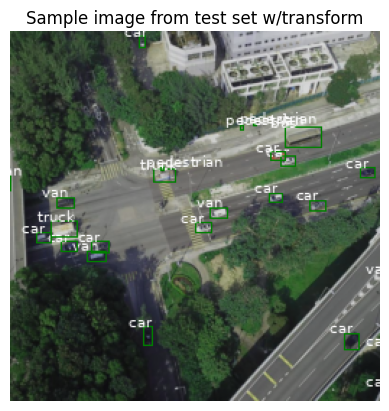

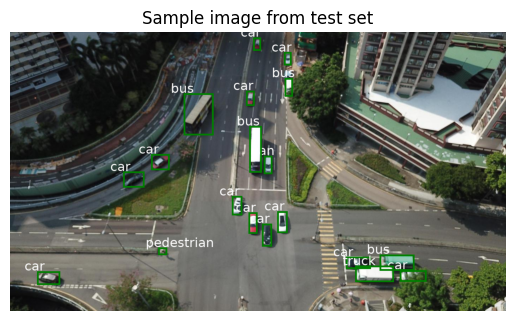

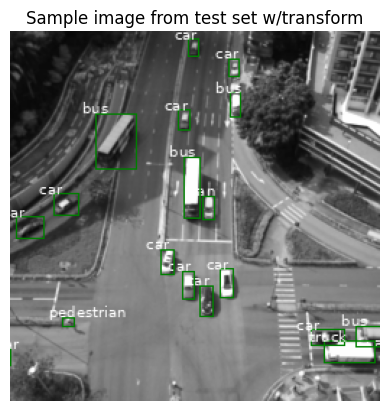

In [22]:
while True:
    ii = []
    ll = []
    split_path = base_path / "train" / "labels"
    label = random.choice(os.listdir(split_path))
    label_file = split_path / label
    image_file = Path(label_file.parent.parent / "images" / label_file.parts[-1]).with_suffix(".jpg")
    x1,y1 = Image.open(image_file).size
    ii.append(image_file)
    ll.append(label_file)
    split_path = base_path / "valid" / "labels"
    label = random.choice(os.listdir(split_path))
    label_file = split_path / label
    image_file = Path(label_file.parent.parent / "images" / label_file.parts[-1]).with_suffix(".jpg")
    ii.append(image_file)
    ll.append(label_file)
    x2,y2 = Image.open(image_file).size
    split_path = base_path / "test" / "labels"
    label = random.choice(os.listdir(split_path))
    label_file = split_path / label
    image_file = Path(label_file.parent.parent / "images" / label_file.parts[-1]).with_suffix(".jpg")
    ii.append(image_file)
    ll.append(label_file)
    x3,y3 = Image.open(image_file).size
    if x1 == x2 == x3 and y1 == y2 == y3:
        break

for image_file, label_file in zip(ii,ll):
    display_image_with_bbox(image_file, label_file, f"Sample image from {split} set")
    display_image_with_bbox(image_file, label_file, f"Sample image from {split} set w/transform", transform=visual_transforms)